# Skin Cancer

In [173]:
import kagglehub
import shutil
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

## 1.1 downloading the dataset

In [174]:
try:
    path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
    shutil.copytree(path, './data/skin-cancer')
except:
    print("folder already exists!")

folder already exists!


## read and resize

In [203]:
all_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  color_mode='rgb',
  seed=123,
  image_size=(30, 30),
  batch_size=32,
  shuffle=True)

Found 3297 files belonging to 2 classes.


## Blancing the dataset with augmentation

In [204]:
def getImgCountPerClass(dataset):
    class1=0
    all=0
    for images, labels in dataset:
        class1+=(sum(labels[i].numpy() for i in range(images.shape[0])))
        all+=images.shape[0]
    return class1, all-class1

In [205]:
print(getImgCountPerClass(all_ds))

(1497, 1800)


In [206]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def separate_classes(dataset):
    class_0_images, class_0_labels = [], []
    class_1_images, class_1_labels = [], []

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if labels[i].numpy() == 0:
                class_0_images.append(images[i].numpy())
                class_0_labels.append(labels[i].numpy())
            else:
                class_1_images.append(images[i].numpy())
                class_1_labels.append(labels[i].numpy())
    
    return (np.array(class_0_images), np.array(class_0_labels)), (np.array(class_1_images), np.array(class_1_labels))

def augment_class(images, labels, target_count, datagen):
    augmented_images, augmented_labels = [], []
    while len(augmented_images) < target_count:
        random.shuffle(images)
        for i in range(len(images)):
            augmented_image = datagen.random_transform(images[i])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images), np.array(augmented_labels)

def balance_classes(dataset, datagen, target_count):
    (class_0_images, class_0_labels), (class_1_images, class_1_labels) = separate_classes(dataset)

    if len(class_0_labels) < target_count:
        class_0_images, class_0_labels = augment_class(class_0_images, class_0_labels, target_count, datagen)
    if len(class_1_labels) < target_count:
        class_1_images, class_1_labels = augment_class(class_1_images, class_1_labels, target_count, datagen)

    balanced_images = np.concatenate([class_0_images, class_1_images], axis=0)
    balanced_labels = np.concatenate([class_0_labels, class_1_labels], axis=0)

    indices = np.arange(len(balanced_labels))
    np.random.shuffle(indices)
    balanced_images = balanced_images[indices]
    balanced_labels = balanced_labels[indices]

    return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

all_ds = balance_classes(all_ds, datagen, int(max(getImgCountPerClass(all_ds))*3)).batch(32)

In [207]:
test_ds = all_ds.take(len(all_ds)//10)
val_ds = all_ds.skip(len(all_ds)//10)
val_ds = val_ds.take(len(val_ds)//9)
train_ds = all_ds.skip(len(all_ds)//5)

In [208]:
train_ds = balance_classes(train_ds, datagen, max(getImgCountPerClass(train_ds))).batch(32)
# val_ds = balance_classes(val_ds, datagen, max(getImgCountPerClass(val_ds))).batch(32)
# test_ds = balance_classes(test_ds, datagen, max(getImgCountPerClass(test_ds))).batch(32)

In [209]:
print(getImgCountPerClass(val_ds))

(510, 546)


## normalization

In [210]:
import matplotlib.pyplot as plt

def preprocess_image(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    # image = tf.image.convert_image_dtype(image, tf.float32) 
    # image = (image - tf.reduce_mean(image)) / tf.math.reduce_std(image)
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

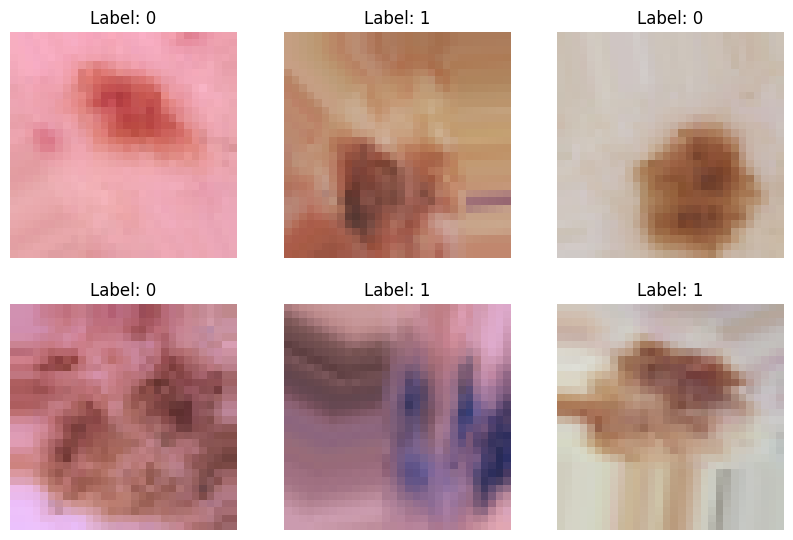

In [211]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()

## Tools for Result Analysis

In [212]:
def plt_acc_loss(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def plt_roc(model):
    y_true = np.concatenate([y for x, y in test_ds], axis=0) 
    y_pred_proba = model.predict(test_ds).ravel()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    plt.figure() 
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc="lower right")

def plt_confusion(model):
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    test_predictions = model.predict(test_ds)
    test_pred_classes = (test_predictions > 0.5).astype(int).ravel()
    cm = confusion_matrix(test_labels, test_pred_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return test_labels, test_pred_classes

## Proposed model without modification

In [237]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu', use_bias=True))
model.add(Dense(units=32, activation='relu', use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_130 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_130               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_131               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_132               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,385 (517.13 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 0 (0.00 B)

In [238]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=128)

test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6487 - loss: 0.6042 - val_accuracy: 0.7348 - val_loss: 0.4953
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7979 - loss: 0.4273 - val_accuracy: 0.8116 - val_loss: 0.3870
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8139 - loss: 0.3968 - val_accuracy: 0.8078 - val_loss: 0.3685
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8246 - loss: 0.3616 - val_accuracy: 0.8191 - val_loss: 0.3664
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8405 - loss: 0.3402 - val_accuracy: 0.7633 - val_loss: 0.4384
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8592 - loss: 0.2953 - val_accuracy: 0.8305 - val_loss: 0.3600
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8760 - loss: 0.2770 - val_accuracy: 0.8419 - val_loss: 0.3517
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8868 - loss: 0.2479 - val_accurac

### Results

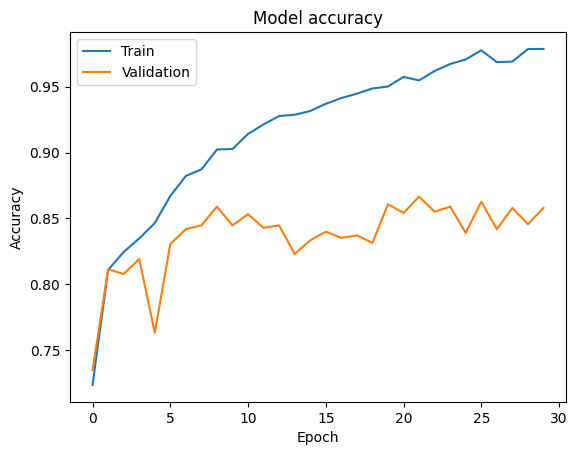

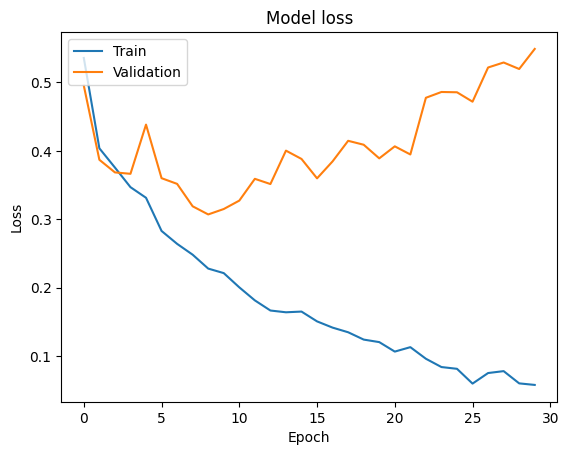

In [239]:
plt_acc_loss(history)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


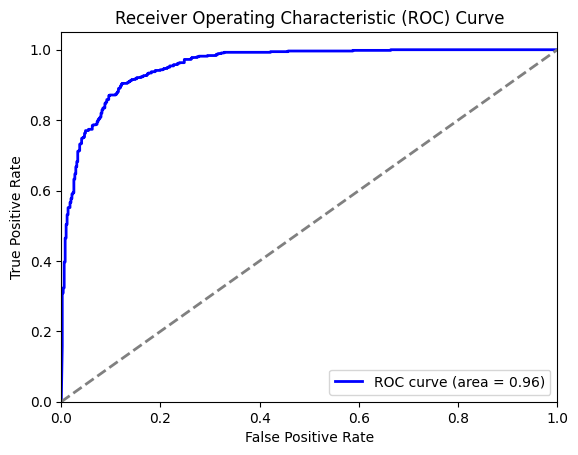

In [240]:
plt_roc(model)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


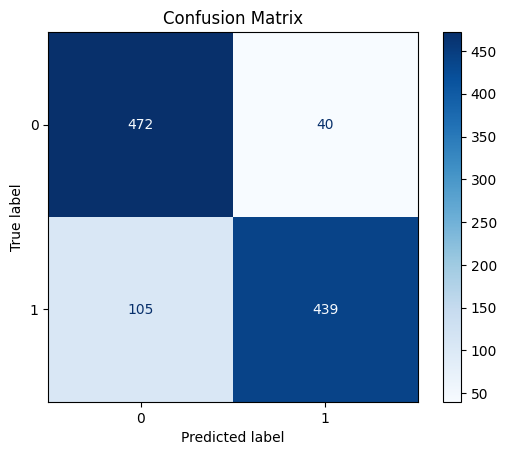

In [241]:
test_labels, test_pred_classes = plt_confusion(model)

In [242]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       512
           1       0.92      0.81      0.86       544

    accuracy                           0.86      1056
   macro avg       0.87      0.86      0.86      1056
weighted avg       0.87      0.86      0.86      1056



## Proposed Model with Dropout

In [246]:
myModel = Sequential()

myModel.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
myModel.add(Dropout(0.4))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))
myModel.add(Dropout(0.2))

myModel.add(Flatten())

myModel.add(Dense(units=32, activation='relu', use_bias=True))
myModel.add(Dense(units=8, activation='relu', use_bias=True))
myModel.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

myModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

myModel.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_138 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_138               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_139               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_140               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_141               │ (None, 2, 2, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,009 (269.57 KB)

 Trainable params: 69,009 (269.57 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
myHistory = myModel.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = myModel.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6664 - loss: 0.6013 - val_accuracy: 0.7737 - val_loss: 0.4443
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7973 - loss: 0.4406 - val_accuracy: 0.7945 - val_loss: 0.4167
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8184 - loss: 0.3952 - val_accuracy: 0.8030 - val_loss: 0.4128
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8336 - loss: 0.3670 - val_accuracy: 0.7888 - val_loss: 0.3988
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8415 - loss: 0.3447 - val_accuracy: 0.8040 - val_loss: 0.3794
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8521 - loss: 0.3231 - val_accuracy: 0.7983 - val_loss: 0.4026
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8581 - loss: 0.3068 - val_accuracy: 0.8305 - val_loss: 0.3551
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8630 - loss: 0.2995 - val_accuracy: 0

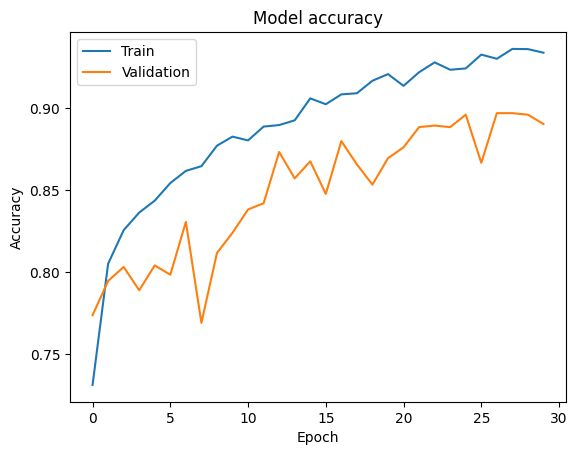

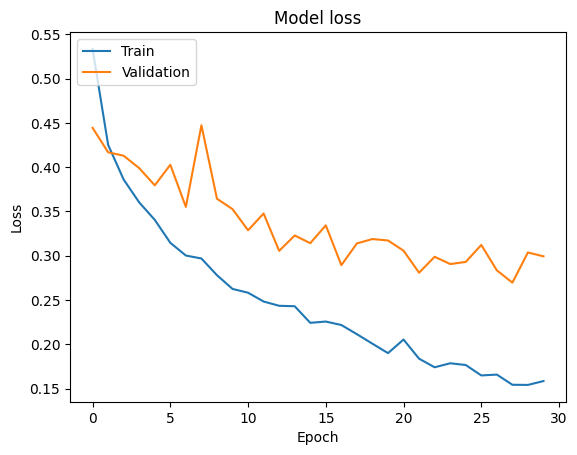

In [248]:
plt_acc_loss(myHistory)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


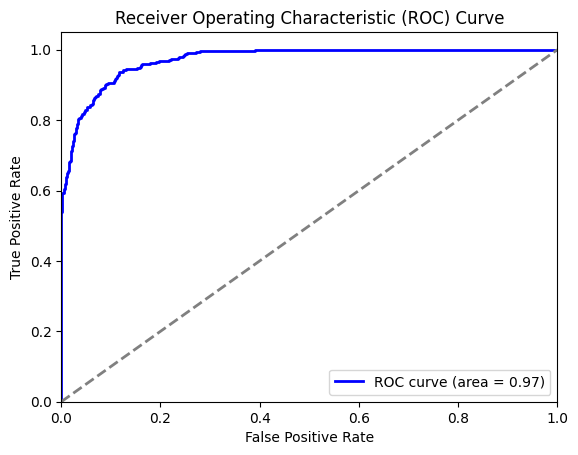

In [249]:
plt_roc(myModel)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


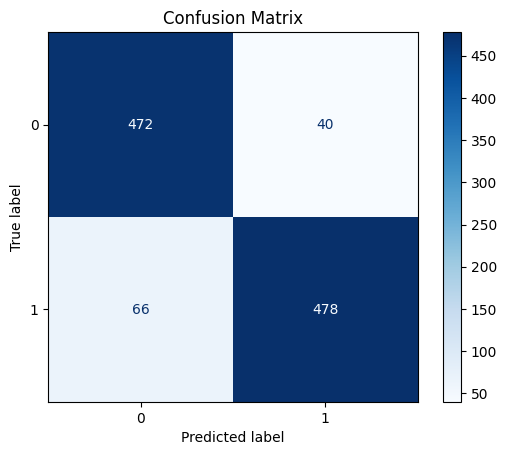

In [250]:
test_labels, test_pred_classes = plt_confusion(myModel)

In [251]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       512
           1       0.92      0.88      0.90       544

    accuracy                           0.90      1056
   macro avg       0.90      0.90      0.90      1056
weighted avg       0.90      0.90      0.90      1056



## Deeper Model

In [265]:
deeperNet = Sequential()

deeperNet.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
deeperNet.add(Dropout(0.4))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Flatten())

deeperNet.add(Dense(units=64, activation='relu', use_bias=True))
deeperNet.add(Dense(units=32, activation='relu', use_bias=True))
deeperNet.add(Dense(units=8, activation='relu', use_bias=True))
deeperNet.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

deeperNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

deeperNet.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_162 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_165 (Conv2D)             │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_165               │ (None, 2, 2, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_166               │ (None, 1, 1, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,953 (406.07 KB)

 Trainable params: 103,953 (406.07 KB)

 Non-trainable params: 0 (0.00 B)

In [266]:
deeperHistory = deeperNet.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=32)

test_loss, test_acc = deeperNet.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5220 - loss: 0.6864 - val_accuracy: 0.7509 - val_loss: 0.5370
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7401 - loss: 0.5373 - val_accuracy: 0.7973 - val_loss: 0.4315
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7899 - loss: 0.4367 - val_accuracy: 0.7955 - val_loss: 0.4198
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8033 - loss: 0.4154 - val_accuracy: 0.8002 - val_loss: 0.4059
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8201 - loss: 0.3881 - val_accuracy: 0.8097 - val_loss: 0.3895
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8395 - loss: 0.3591 - val_accuracy: 0.7775 - val_loss: 0.4411
Epoch 7/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8514 - loss: 0.3463 - val_accuracy: 0.8201 - val_loss: 0.3726
Epoch 8/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8608 - loss: 0.3141 - val_accuracy: 0.

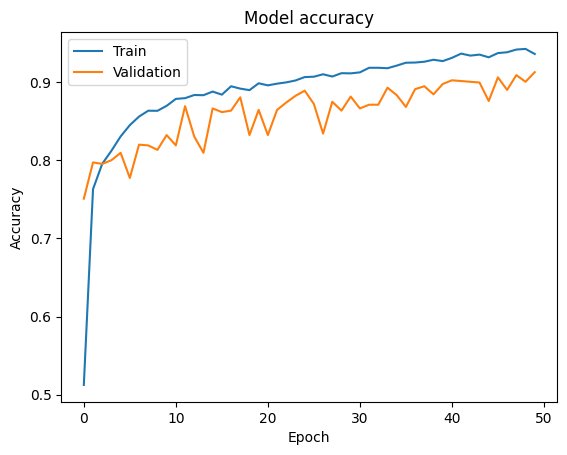

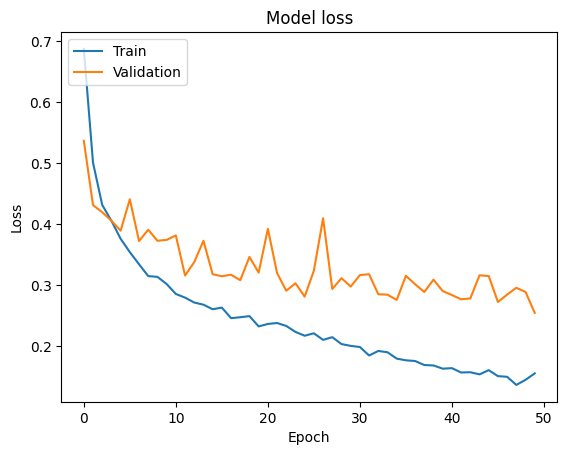

In [267]:
plt_acc_loss(deeperHistory)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


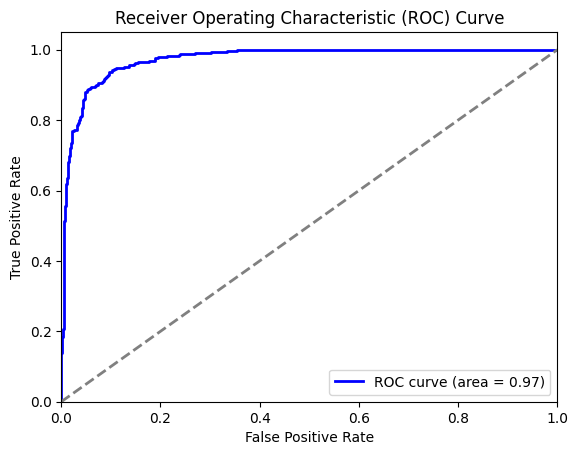

In [268]:
plt_roc(deeperNet)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


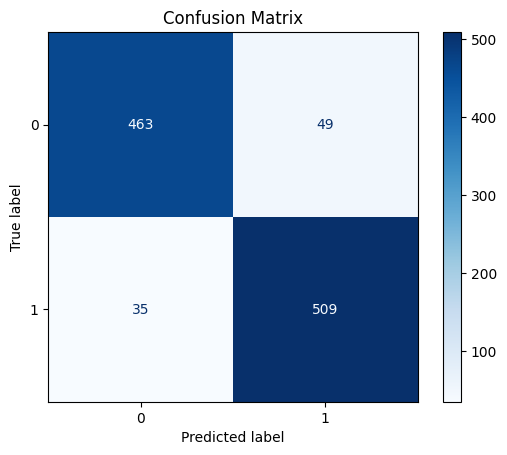

In [272]:
test_labels, test_pred_classes = plt_confusion(deeperNet)

In [273]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       512
           1       0.91      0.94      0.92       544

    accuracy                           0.92      1056
   macro avg       0.92      0.92      0.92      1056
weighted avg       0.92      0.92      0.92      1056

